<center>

# Group Testing with features
## A project for the class "Mathematics and Optimal Transport for Data Science"
### Linus Bleistein
    

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import torch
import sys
import cvxpy as cp
import tqdm
import importlib
import sklearn
import pandas as pd

In [2]:
import reconstruction_alg as rec
from utils import *

# A first glimpse at reconstruction algorithms 

For this project, we implement 4 different "reconstruction algorithms". Given a test matrix $\mathbf{M}$ of size $T \times n$ and a test result $\mathbf{y}$ in $\left\{0,1 \right\}^T$, these algorithms seek to reconstruct the vector $ \mathbf{x} \in \left\{0,1\right\}^n$ that is linked to $\mathbf{y}$ and $\mathbf{M}$ through the relation 

$$ \mathbf{y} =  \mathbf{M} \mathbf{x}.$$

More precisions are given in the companion .pdf file to this project. 

Let us first introduce small utility functions. 
- The function `vsparse_input(n,k,p,iid=False)` creates an vector in $\left\{0,1\right\}^n$ in the very sparse regime (see companion pdf file for details). If `iid=False`, the vector is generated with a combinatorial prior, the number of defectives being equal to `k`. If `iid=True`, the vector is generated according to a iid prior, were entries are set to 1 with probability `p`. 
- The function `sparse_input(n,alpha)` creates an input vector in $\left\{0,1\right\}^n$ in the sparse regime. The number of defectives is equal to $int(n^\alpha)$.
- The function `linear_input(n,beta)` generates an input vector in $\left\{0,1\right\}^n$ of which $\beta \times n$ entries are set to 1.

In [8]:
x = vsparse_input(100,3,0,iid=False)
print(x)

x = sparse_input(100,1/2)
print(x)

x = linear_input(100,0.8)
print(x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
[1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 1.]


The function `b_tests(T,n,p)` creates a test matrix $\mathbf{M}$ of size $T \times n$ (i.e. $T$ tests for a population of $n$ individuals)  with entries in $\left\{0,1 \right\}$ set randomly to 1 with probability alpha - this corresponds to the so-called "Bernouilli test design".

In [9]:
m = b_tests(4,100,0.1)
print('This is the test matrix:',m)
print('This is the test result:',np.int32(m@x >= 1))

This is the test matrix: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]]
This is the test result: [1 1 1 1]


Conversly, `ctpi_tests(T,n,L)` creates a test matrix $\mathbf{M}$ of size $T \times n$ such that every item is tested $L$ times, i.e. every column sums to $L$. This framework is called constant tests-per-item design.

In [3]:
print(ctpi_tests(10,10,3))

[[0 0 0 0 0 1 0 0 0 1]
 [0 0 1 1 0 0 0 1 1 0]
 [0 1 0 1 1 0 1 0 0 0]
 [0 1 0 0 0 1 0 0 0 0]
 [1 0 1 0 0 0 0 1 0 0]
 [0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 1 1 1]
 [1 0 0 0 1 0 0 0 1 0]
 [1 0 0 0 0 1 1 0 0 1]]


## The COMP algorithm

The COMP algorithm is the most basic one can think of: given a test result and a test matrix, it declares as healthy all individuals that are in negative tests, and positive all others. It is conservative in the sens that it only makes false positives, and no false negatives.
You can instanciate the algorithm with a true vector $\mathbf{x}$ and a test matrix $\mathbf{M}$ by calling `COMP(true_x,test_matrix)`. Methods and a more detailled description of the algorithm can be found by calling `help()`.

In [124]:
comp = rec.COMP(x,m)

`reconstruct()` gives the approximation of the true vector $\mathbf{x}$ computed by the algorithm. 

In [125]:
print(comp.reconstruct())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


`score()` computes the 0-1 loss.

In [126]:
print(comp.score())

0.1


The `average_score(mat_size,number,alpha)` can be used to perform a test of the COMP algorithm: for a given true vector given when instanciating, it computes the average score over `number` test matrices with `mat_size` tests, whose inputs are randomly and independantly set to 0 with probability `alpha`.  

In [24]:
print(comp.average_score(70,1000,0.9))

0.9257400000000034


Finally, the method `confusion_matrix(plot=False,absv=False)` yields the confusion matrix of the algorithm. If `plot=True`, it plots it using `seaborn`. If `absv=True`, it gives absolute values instead of percentages.  

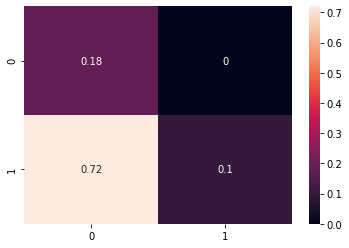

In [33]:
comp.confusion_matrix(plot=True)

## The DD algorithm

The DD algorithm works in three stages:
- It performs a COMP stage 
- It then declares positive all individuals that are in tests groups from which all other members have been declared healthy in the previous step. 
- Finally, it classifies as healthy all remaining individuals. 

This last step is motivated by the high sparsity of the vector $x$: since $x$ is sparse, there is little chance to create false negatives. Notice also that this algorithm only makes false negatives.  
Methods and instanciation are identical to the COMP algorithm.

0.8800000000000001
0


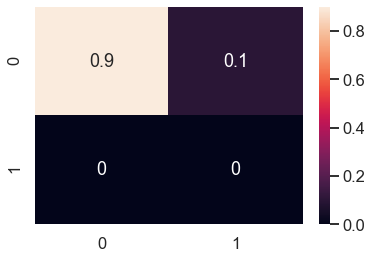

In [94]:
dd = rec.DD(x,m)
print(comp.f1score())
print(dd.precision())
dd.confusion_matrix(plot=True)

## The SCOMP algorithm

The SCOMP algorithm works in a recursive manner:
- It first performs the two first steps of the DD algorithm, but without declaring all non identified individuals as healthy. This produces an estimated vector $\mathbf{\tilde{x}}$.
- It then iteratively checks if $ \mathbf{y}=\mathbf{M}\mathbf{\tilde{x}}$. If not, it identifies the individual which is present in the greatest number of unexplained tests (i.e. positive tests which do not include any individual that is already known to be positive) and declares her positive. 

Methods and instanciation are identical.

0.89


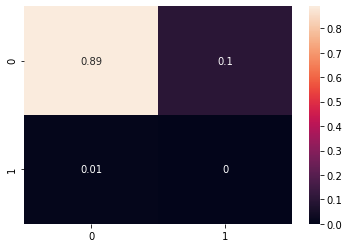

In [6]:
scomp = rec.SCOMP(x,m)
print(scomp.score())
scomp.confusion_matrix(plot=True)

## The LP relaxation algorithm

The LP relaxation algorithm computes an estimation by solving an convex optimization problem, which is a relaxed version of the non-convex combinatorial problem of group testing. The solver used here is CVXPY. Methods and instanciation are identical.

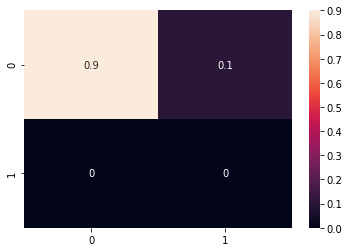

In [13]:
lp = rec.LP(x,m)
lp.score()
lp.confusion_matrix(plot=True)

## Some first comparaisons

Let us first compare the algorithms based on their average scores while varying the matrix size.  

In [69]:
#Hyperparameters 

test_sample = 100
matrix_alpha = 0.9
x_sparsness = 1-1/50
x_size = 500
mat_size = 150

In [70]:
importlib.reload(rec)

comp_scores = np.zeros(mat_size)
dd_scores = np.zeros(mat_size)
scomp_scores = np.zeros(mat_size)
lp_scores= np.zeros(mat_size)


for grouptest in tqdm.tqdm(np.arange(test_sample)):
    
    matrix = create_tests(mat_size,x_size,matrix_alpha)
    true_x = create_input(x_size,x_sparsness)
    
    for size in np.arange(0,mat_size):
        
        test_matrix = matrix[0:size+1,:]
        comp = rec.COMP(true_x,test_matrix)
        comp_scores[size] += comp.precision()
        dd = rec.DD(true_x,test_matrix)
        dd_scores[size] += dd.precision()
        scomp = rec.SCOMP(true_x,test_matrix)
        scomp_scores[size] += scomp.precision()
        lp = rec.LP(true_x,test_matrix)
        lp_scores[size] += lp.precision()
        
comp_scores *= 1/test_sample
scomp_scores *= 1/test_sample
dd_scores *= 1/test_sample
lp_scores *= 1/test_sample
        
        
        
        

100%|██████████| 100/100 [12:12<00:00,  7.32s/it]


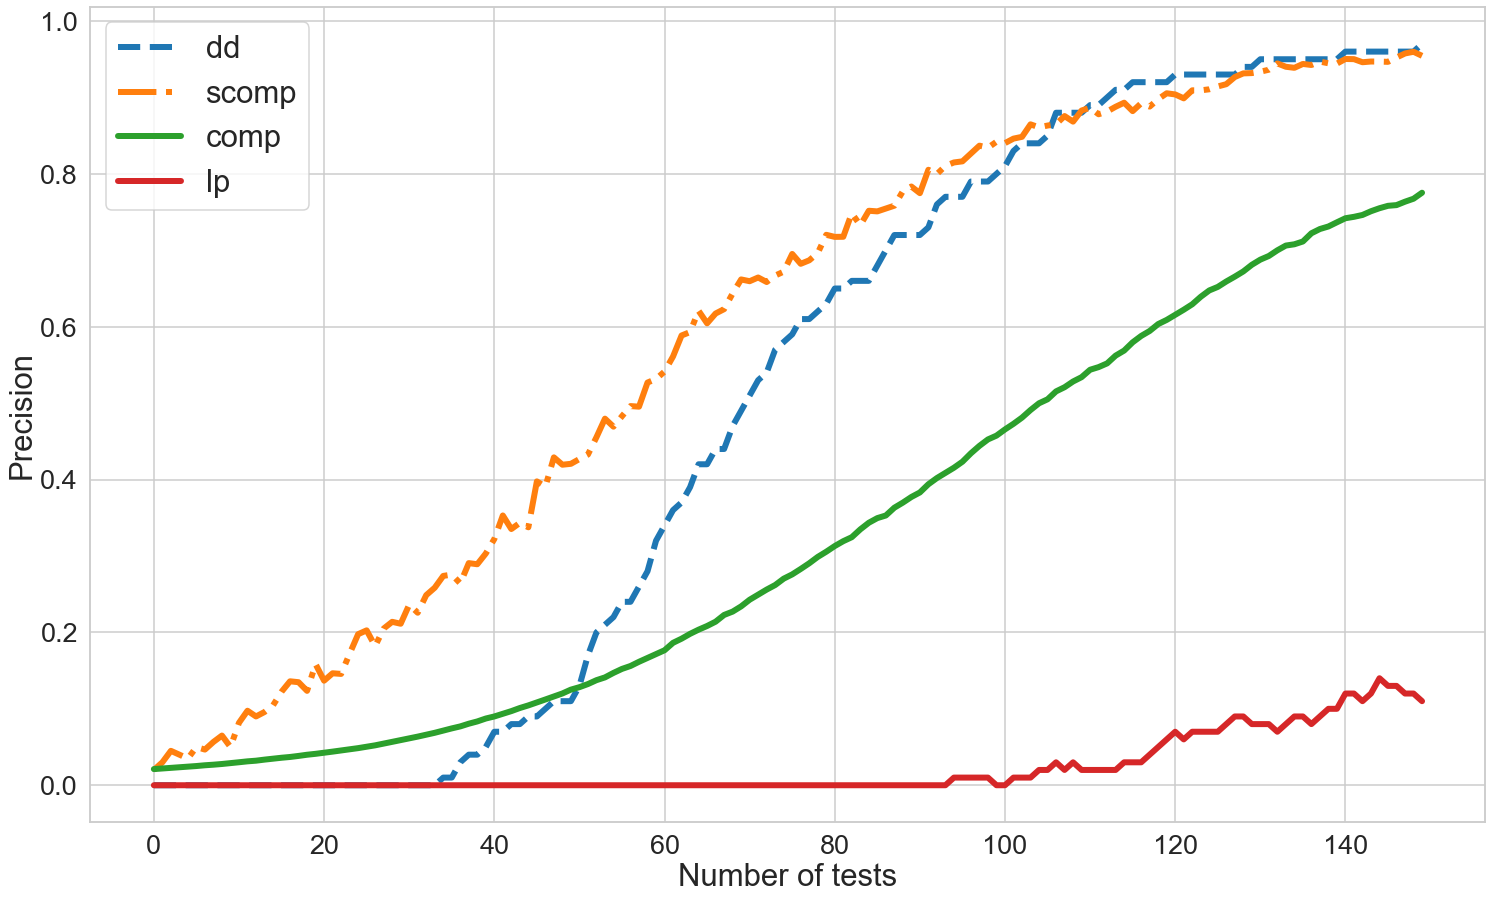

In [85]:
sns.set_context('talk')
sns.set_style('whitegrid')

f,ax = plt.subplots(figsize=(25,15))

ax.plot(dd_scores, label='dd',linestyle='--', linewidth=6)
ax.plot(scomp_scores, label ='scomp',linestyle='-.', linewidth=6)
ax.plot(comp_scores, label = 'comp', linewidth=6)
ax.plot(lp_scores,label='lp', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Precision', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)


plt.show()

## Group testing with features - a toy example

This section showcases our group testing pipeline on a toy example. 

Consider a classification task, with a dataset that is badly separable by logistic regression, as displayed bellow.

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


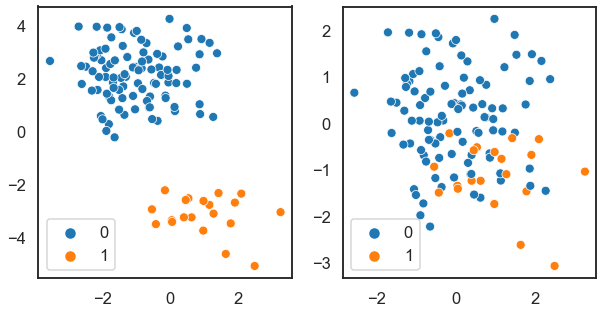

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.datasets import make_blobs

sns.set_style('white')
sns.set_context('talk')

x1, y1 = make_blobs(n_samples=[100,20], n_features=2,
                  random_state=0, centers=np.array([[-1,2],[1,-3]]))
x2, y2 = make_blobs(n_samples=[100,20], n_features=2,
                  random_state=0, centers=np.array([[0,0],[1,-1]]))

f,ax=plt.subplots(1,2,figsize=(10,5))

sns.scatterplot(x1[:,0],x1[:,1],hue=y1,alpha=1, ax=ax[0])
sns.scatterplot(x2[:,0],x2[:,1],hue=y2,alpha=1, ax=ax[1])

plt.legend()
plt.show()

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


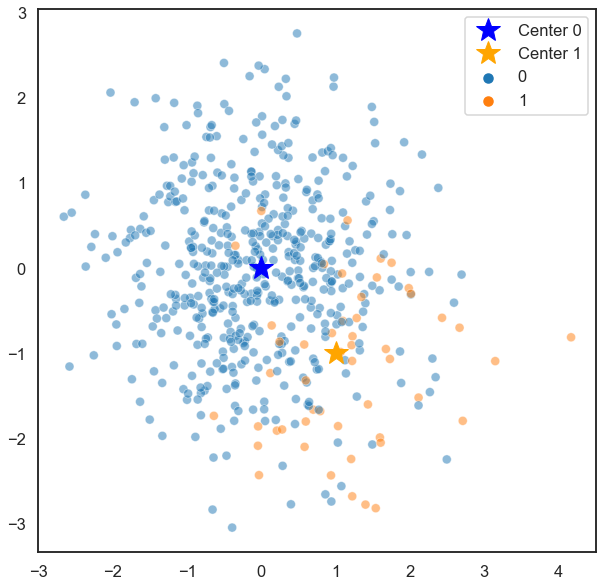

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=[500,50], n_features=2,
                  random_state=0, centers=np.array([[0,0],[1,-1]]))

f,ax=plt.subplots(figsize=(10,10))

sns.scatterplot(X[:,0],X[:,1],hue=y,alpha=0.5)
plt.plot(0,0,marker='*',markersize=25,c='blue',linestyle='',label='Center 0')
plt.plot(1,-1,marker='*',markersize=25,c='orange',linestyle='',label='Center 1')
plt.legend()
plt.show()


In our setting, we have such a dataset that includes features, and we would like to use the information contained in these features to improve our group testing pipeline. Based on the features, some datapoints can indeed be classified with very high probability as 'sick' or 'healthy', and might thus not need further testing through group testing. We can then narrow down our research to suspicious datapoints, i.e. points that are classified with probability close to 1/2, and only perform group testing on those points. By doing so, we reduce our sample size, which in turn reduces the number of group tests needed to obtain high precision.

Let us first split our dataset and train a logistic classifier.

In [113]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('Proportion of sick in training set:', np.mean(y_train))
      
print('Proportion of sick in testing set:',np.mean(y_test))

Proportion of sick in training set: 0.08863636363636364
Proportion of sick in testing set: 0.1


In [114]:
clf = LogisticRegression().fit(x_train, y_train)

Accuracy of the classifier on test set: 0.9454545454545454
Accuracy of the classifier on training set: 0.9022727272727272


/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


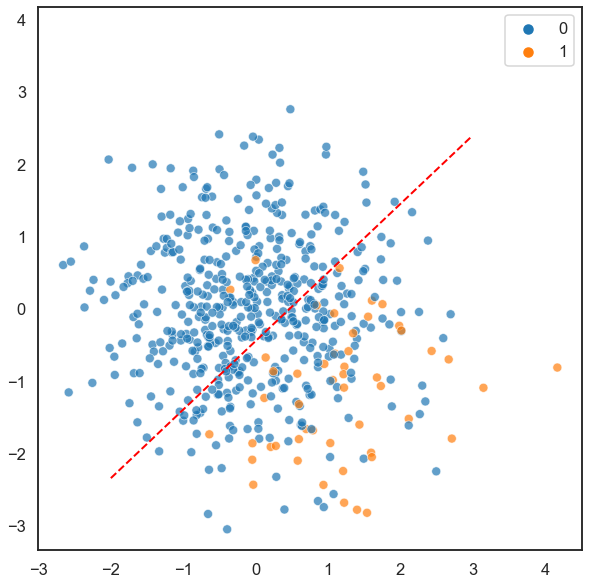

In [115]:
print('Accuracy of the classifier on test set:', clf.score(x_test,y_test))
print('Accuracy of the classifier on training set:',clf.score(x_train,y_train))

param1 = clf.coef_[0,0]
param2 = clf.coef_[0,1]

sns.set_context('talk')
sns.set_style('white')

f,ax=plt.subplots(figsize=(10,10))

points = np.arange(start=-2,stop=3,step=0.001)
sns.lineplot(x=points,y=1/param2*(1/2-param1*points),linestyle='--',linewidth=2,color='red')
sns.scatterplot(X[:,0],X[:,1],hue=y,alpha=0.7)
plt.axis('square')
plt.show()

In [116]:
prediction = clf.predict(x_test)

cm = sklearn.metrics.confusion_matrix(y_test, prediction)
print(cm)

true_positives = cm[1,1]
total_positives = cm[0,1] + true_positives

print("precision of the logistic classifier:",true_positives/total_positives)

[[98  1]
 [ 5  6]]
precision of the logistic classifier: 0.8571428571428571


Because to the noisy data, our classifier is not very precise... The cell bellow builds a dataframe for more clarity.

In [117]:
probas = clf.predict_proba(x_test)[:,0]

predicted = clf.predict(x_test)

length = len(x_test)

data = np.concatenate((y_test.reshape(length,1),x_test,probas.reshape(length,1),predicted.reshape(length,1),predicted.reshape(length,1)),axis=1)

data = data.reshape(length,6)

df = pd.DataFrame(data,columns=['True status','Feature 1','Feature 2','Predicted probability','Predicted status','Rectified status'])

print(df)


     True status  Feature 1  Feature 2  Predicted probability  \
0            1.0   2.433353  -0.581602               0.565078   
1            0.0   0.470433   0.311447               0.966271   
2            1.0   1.224252  -2.678688               0.308301   
3            0.0  -1.582938   0.610379               0.997204   
4            0.0  -0.637437  -0.397272               0.976749   
..           ...        ...        ...                    ...   
105          0.0  -2.094603   0.123722               0.997198   
106          0.0  -1.045253   1.211145               0.997477   
107          0.0   0.275601   1.435049               0.992040   
108          0.0   0.481115   2.759355               0.997751   
109          0.0   0.614079   0.922207               0.979937   

     Predicted status  Rectified status  
0                 0.0               0.0  
1                 0.0               0.0  
2                 1.0               1.0  
3                 0.0               0.0  
4        

Our strategy is the following: if the probability of belonging to the predicted class is the interval $[1/2 - threshhold;1/2+threshhold]$, we select this individual for group testing.

This threshhold selects 12 items for group testing, i.e. 10.909090909090908 percent of the test set.


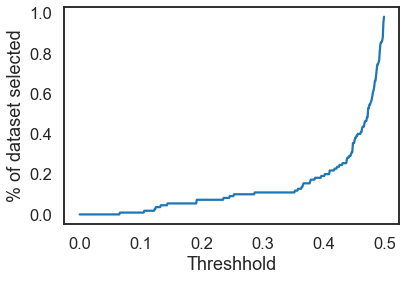

In [127]:
#Select all cases wich are close to the decision boundary

threshhold = 0.3

points = np.arange(0,0.5,1/1000)

values=[]

for point in points:
    
    suspicious_cases = df[np.abs(df.iloc[:,3]-1/2) < point]
    
    values.append(len(suspicious_cases)/len(y_test))

suspicious_cases = df[np.abs(df.iloc[:,3]-1/2) < threshhold]

print('This threshhold selects {} items for group testing, i.e. {} percent of the test set.'.format(len(suspicious_cases),100*len(suspicious_cases)/len(y_test)))

plt.plot(points,values)
plt.xlabel('Threshhold')
plt.ylabel('% of dataset selected')
plt.show()


/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


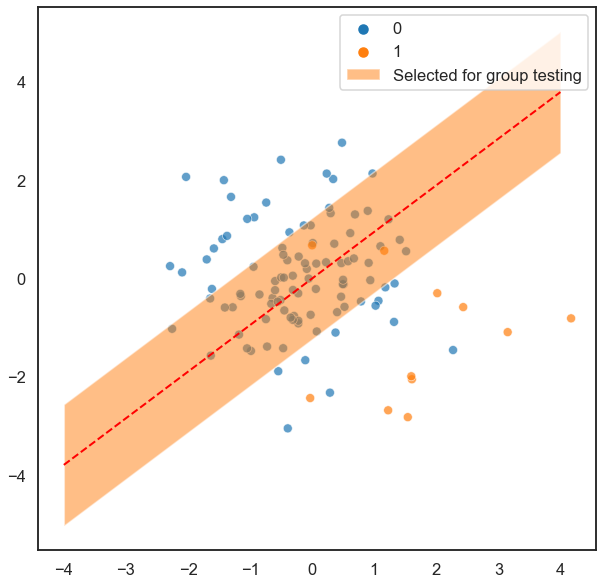

In [132]:
param1 = clf.coef_[0,0]
param2 = clf.coef_[0,1]

sns.set_context('talk')
sns.set_style('white')

f,ax=plt.subplots(figsize=(10,10))

points = np.arange(start=-4,stop=4,step=0.001)
y_plus = 1/param2*(np.log((1-2*threshhold)/(1+2*threshhold))-param1*points)
y_minus = 1/param2*(np.log((1+2*threshhold)/(1-2*threshhold))-param1*points)
sns.lineplot(x=points,y=1/param2*(-param1*points),linestyle='--',linewidth=2,color='red')
#sns.scatterplot(X[:,0],X[:,1],hue=y,alpha=0.7)
sns.scatterplot(x_test[:,0],x_test[:,1],hue=y_test,alpha=0.7)
ax.fill_between(points,y_minus,y_plus,alpha=0.5,label='Selected for group testing')
#plt.axis('square')
plt.legend()
plt.show()

In [86]:
true_s_y = suspicious_cases.iloc[:,0]

print(true_s_y)

mat_size=70

matrix = create_tests(mat_size,len(true_s_y),0.99)

dd = rec.DD(true_s_y,matrix)

print(dd.precision())

print(dd.accuracy())

print(dd.recall())

reconstruct = dd.reconstruct()

print(reconstruct.shape)

df.loc[np.abs(df.iloc[:,3]-1/2) < threshhold,'Rectified status'] = reconstruct

print(df)

1      1.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
99     1.0
102    0.0
106    0.0
107    0.0
108    0.0
Name: True status, Length: 66, dtype: float64
1.0
0.8787878787878788
0.3333333333333333
(66,)
     True status  Feature 1  Feature 2  Predicted probability  \
0            0.0  -1.824257   0.303604               0.998934   
1            1.0   1.214966  -0.902781               0.773324   
2            0.0   1.319137  -0.882419               0.750963   
3            0.0   0.589880  -0.363859               0.937476   
4            0.0   0.862596  -2.655619               0.440307   
..           ...        ...        ...                    ...   
105          0.0   0.364481   1.471322               0.993805   
106          0.0  -0.190653  -0.394850               0.977434   
107          0.0   0.528944   0.246148               0.969992   
108          0.0   1.326462  -0.964606               0.731352   
109          0.0  -0.895467   0.386902               0.996433   

    

In [87]:
conf_mat = sklearn.metrics.confusion_matrix(y_test, df['Predicted status'])
print(conf_mat)

conf_mat_rectified = sklearn.metrics.confusion_matrix(y_test, df['Rectified status'])
print(conf_mat_rectified)

true_positives = conf_mat[1,1]
false_neg = conf_mat[1,0]
total_positives = conf_mat[0,1] + true_positives

print("precision for non rectified:",true_positives/total_positives)
print("recall for non rectified:", true_positives/(true_positives+false_neg))
print("Accuracy for non rectified:", (conf_mat[0,0]+conf_mat[1,1])/np.sum(conf_mat))

true_positives = conf_mat_rectified[1,1]
total_positives = conf_mat_rectified[0,1] + true_positives
false_neg = conf_mat_rectified[1,0]

print("precision for rectified:",true_positives/total_positives)
print("recall for rectified:", true_positives/(true_positives+false_neg))
print("Accuracy for rectified:", (conf_mat_rectified[0,0]+conf_mat_rectified[1,1])/np.sum(conf_mat_rectified))


[[95  1]
 [12  2]]
[[96  0]
 [10  4]]
precision for non rectified: 0.6666666666666666
recall for non rectified: 0.14285714285714285
Accuracy for non rectified: 0.8818181818181818
precision for rectified: 1.0
recall for rectified: 0.2857142857142857
Accuracy for rectified: 0.9090909090909091


As we can see, the precision of our prediction is greatly improved by using as little as 50 tests. 

In [48]:
from importlib import reload 
from utils import generate_blobs
reload(utils)

data = generate_blobs()

print(data)

     True status  Feature 1  Feature 2  Predicted probability  \
0            0.0  -0.762115  -0.887780               0.966401   
1            1.0   1.348169  -0.336742               0.780484   
2            0.0  -0.861226   1.910065               0.998219   
3            0.0   0.521065  -0.575788               0.887396   
4            0.0   0.039767  -1.566995               0.840372   
..           ...        ...        ...                    ...   
108          0.0  -0.347912   0.156349               0.980171   
109          1.0   1.731659  -1.065488               0.511407   
110          0.0  -0.532703   1.090750               0.993837   
111          0.0  -0.399449   0.370056               0.984972   
112          1.0   2.712305  -1.792115               0.127280   

     Predicted status  Rectified status  
0                 0.0               0.0  
1                 0.0               0.0  
2                 0.0               0.0  
3                 0.0               0.0  
4        

In [100]:
n_tests = 100
max_test_size = 70
samplesize=500
threshold = 0.3

enhanced_dd_scores = np.zeros(max_test_size)
dd_scores = np.zeros(max_test_size)

comp_scores = np.zeros(max_test_size)
enhanced_comp_scores = np.zeros(max_test_size)

scomp_scores = np.zeros(max_test_size)
enhanced_scomp_scores = np.zeros(max_test_size)

for test in tqdm.tqdm(np.arange(n_tests)): 
    
    data = generate_blobs(samplesize)
    
    full_sample_y = data["True status"]
    
    full_rectified = data["Rectified status"]
    
    full_predicted = data["Predicted status"]
    
    suspicious_cases = data[np.abs(data.iloc[:,3]-1/2) < threshold]
    
    suspicious_y = suspicious_cases.iloc[:,0]
    
    p = 1/(true_s_y.mean()*len(true_s_y))
    
    enhanced_matrix = b_tests(max_test_size,len(suspicious_y),p)
    
    full_matrix = b_tests(max_test_size,len(full_sample_y),p)
    
    for size in np.arange(0,max_test_size):
        
        full_rectified = data["Rectified status"]
        
        enhanced_test_matrix = enhanced_matrix[0:size+1,:]
        test_matrix = full_matrix[0:size+1,:]

        dd = rec.DD(full_sample_y,test_matrix)
        dd_scores[size] += dd.precision()
        
        comp = rec.COMP(full_sample_y,test_matrix)
        comp_scores[size] += comp.precision()
        
        scomp = rec.SCOMP(full_sample_y,test_matrix)
        scomp_scores[size] += scomp.precision()
        
        enhanced_dd = rec.DD(suspicious_y,enhanced_test_matrix)
        enhanced_comp = rec.COMP(suspicious_y,enhanced_test_matrix)
        enhanced_scomp = rec.SCOMP(suspicious_y,enhanced_test_matrix)
        
        dd_reconstructed_suspicious = enhanced_dd.reconstruct()
        comp_reconstructed_suspicious = enhanced_comp.reconstruct()
        scomp_reconstructed_suspicious = enhanced_scomp.reconstruct()
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < threshold] = dd_reconstructed_suspicious
        
        confusion_matrix = sklearn.metrics.confusion_matrix(full_sample_y,full_rectified)
        
        true_positives = confusion_matrix[1,1]
        total_positives = confusion_matrix[0,1] + true_positives
        
        if total_positives == 0:
            
            enhanced_dd_scores[size] = 1
        
        else:
        
            enhanced_dd_scores[size] += true_positives/total_positives
            
        full_rectified[np.abs(data.iloc[:,3]-1/2) < threshold] = comp_reconstructed_suspicious
        
        confusion_matrix = sklearn.metrics.confusion_matrix(full_sample_y,full_rectified)
        
        true_positives = confusion_matrix[1,1]
        total_positives = confusion_matrix[0,1] + true_positives
        
        if total_positives == 0:
            
            enhanced_comp_scores[size] = 1
        
        else:
        
            enhanced_comp_scores[size] += true_positives/total_positives
            
        full_rectified[np.abs(data.iloc[:,3]-1/2) < threshold] = scomp_reconstructed_suspicious
        
        confusion_matrix = sklearn.metrics.confusion_matrix(full_sample_y,full_rectified)
        
        true_positives = confusion_matrix[1,1]
        total_positives = confusion_matrix[0,1] + true_positives
        
        if total_positives == 0:
            
            enhanced_scomp_scores[size] = 1
        
        else:
        
            enhanced_scomp_scores[size] += true_positives/total_positives
        
        
        


enhanced_dd_scores *= 1/n_tests
dd_scores *= 1/n_tests

comp_scores *= 1/n_tests
enhanced_comp_scores *= 1/n_tests

scomp_scores *= 1/n_tests
enhanced_scomp_scores *= 1/n_tests
    
    

    
    
    

100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


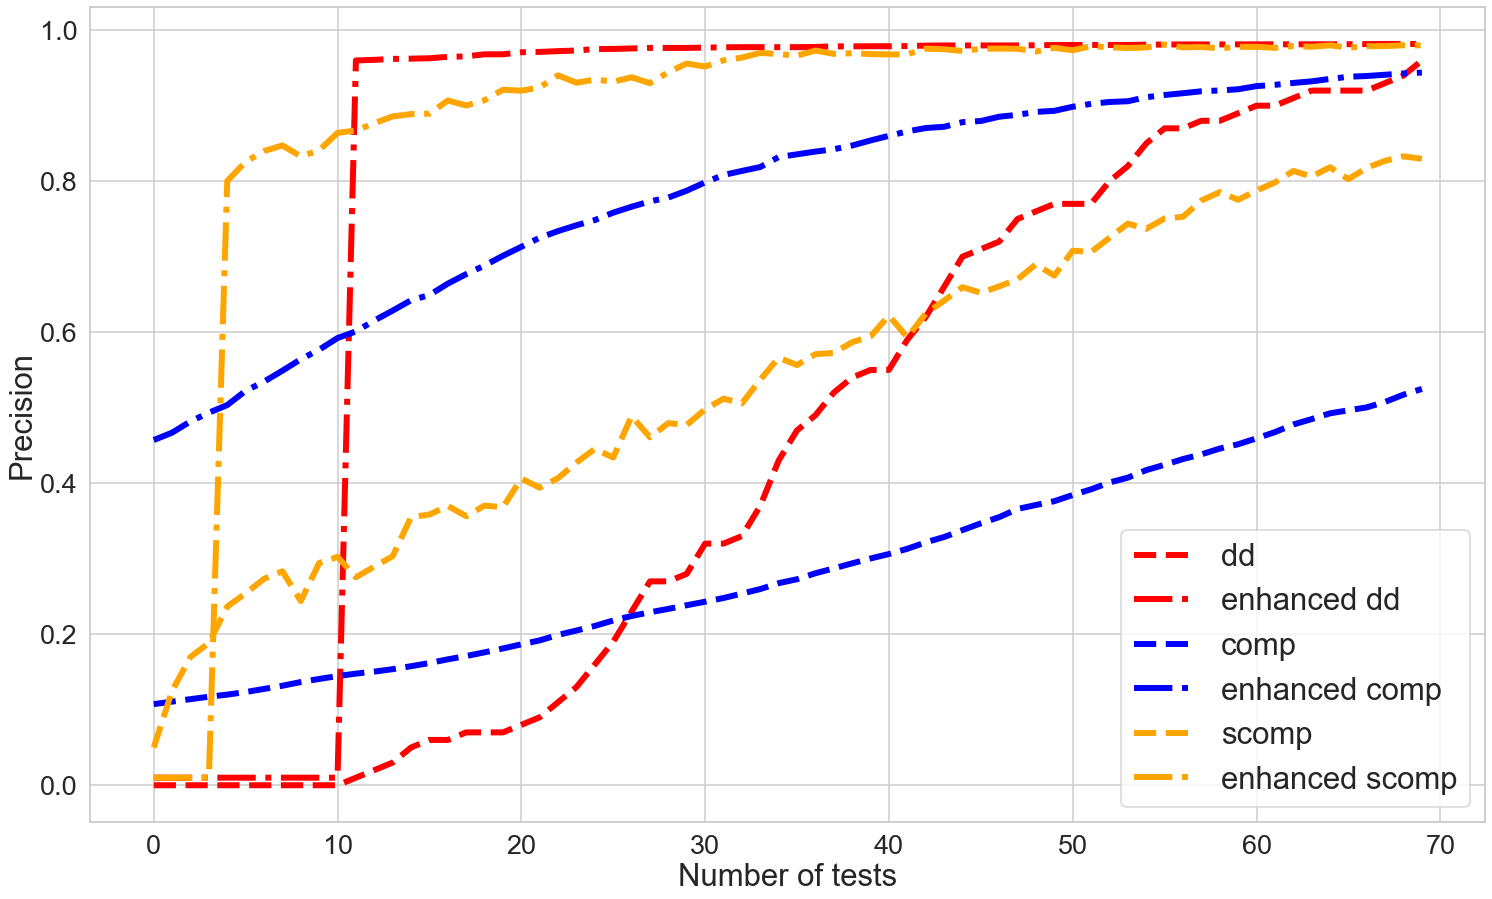

In [109]:
sns.set_context('talk')
sns.set_style('whitegrid')

f,ax = plt.subplots(figsize=(25,15))

ax.plot(dd_scores, label='dd',linestyle='--', c='red', linewidth=6)
ax.plot(enhanced_dd_scores, label ='enhanced dd',linestyle='-.', c='red',linewidth=6)
ax.plot(comp_scores, label='comp',linestyle='--',c='blue', linewidth=6)
ax.plot(enhanced_comp_scores, label ='enhanced comp',linestyle='-.',c='blue', linewidth=6)
ax.plot(scomp_scores, label='scomp',linestyle='--',c='orange', linewidth=6)
ax.plot(enhanced_scomp_scores, label ='enhanced scomp',linestyle='-.',c='orange', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Precision', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)


plt.show()

